# Asterisc Technocrat

## Task 4 - Instagram Reach Forecasting

![Instagram Reach](Instagram.png)



### Introduction

In this task, I've successfully implemented the concept of Time Series Forecasting for forecasting the Instagram Reach using SARIMAX (Seasonal Auto-Regressive Integrated Moving Average with Exogenous variables) 

### Project Overflow
- 1. Importing the dependencies - The required libraries and modules are imported 
- 2. Data Collection - The data is given in the task form, so we need to load it to a Pandas dataframe with proper encoding
- 3. Exploratory Data Analysis - The dataframe is analysed for any missing values or outliers. Additionally, the relationship and trend between the variables using visualizations.
- 4. Stationary test - For SARIMAX model to work efficiently, we test the data for the stationary check.
- 5. Model Building - With the help of ACF and PACF Plots, we get the required parameters for training the SARIMAX Model
- 6. Prediction & Visual Inspection - The model is then used to predict the next required days of Instagram reach. The predicted values are then visually analyzed in order to get a better perspective of the predictions.

Now let us begin our project !

## 1. Importing the dependencies

The required libraries and tools are imported for working with the project

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px
import kaleido.scopes.plotly
import plotly.offline as pyo
from kaleido.scopes.plotly import PlotlyScope
pio.templates.default = 'ggplot2'

## 2. Data Collection

The csv dataset named 'Instagram-Reach.csv' is loaded into the dataframe named 'df'

In [2]:
df = pd.read_csv('Instagram-Reach.csv', encoding = 'latin-1')

In [3]:
df.head()

,Date,Instagram reach
0,2022-04-01T00:00:00,7620
1,2022-04-02T00:00:00,12859
2,2022-04-03T00:00:00,16008
3,2022-04-04T00:00:00,24349
4,2022-04-05T00:00:00,20532


## 3. Exploratory Data Analysis

The loaded dataset is analysed for any missing values or any outliers. Additionally, some effective visualizations have been performed to get the understanding of the model.

In [4]:
df.isnull().sum()

Date               0
Instagram reach    0
dtype: int64

Here, the date column has been converted from object datatype to datetime datatype

In [5]:
df['Date'] = pd.to_datetime(df['Date'])

**Visualizations**

In [8]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['Date'], 
                         y=df['Instagram reach'], 
                         mode='lines', name='Instagram reach'))
fig.update_layout(title='Instagram Reach Trend', xaxis_title='Date', 
                  yaxis_title='Instagram Reach')
# Set the mathjax configuration to None
kaleido_scope = kaleido.scopes.plotly.PlotlyScope(mathjax=None)

# Save the plot as an image
pio.write_image(fig, "plot1.png", engine = "kaleido")

![Plot](plot1.png)

In [9]:
fig = go.Figure()
fig.add_trace(go.Bar(x=df['Date'], 
                     y=df['Instagram reach'], 
                     name='Instagram reach'))
fig.update_layout(title='Instagram Reach by Day', 
                  xaxis_title='Date', 
                  yaxis_title='Instagram Reach')
# fig.show()
# Set the mathjax configuration to None
kaleido_scope = kaleido.scopes.plotly.PlotlyScope(mathjax=None)

# Save the plot as an image
pio.write_image(fig, "plot2.png", engine = "kaleido")

![Plot](plot2.png)

In [10]:
fig = go.Figure()
fig.add_trace(go.Box(y = df['Instagram reach'], name = 'Box Plot'))
fig.update_layout(title = 'Instagram Reach Distribution', xaxis_title = 'Date', yaxis_title = 'Instagram Reach')
# fig.show()
# Set the mathjax configuration to None
kaleido_scope = kaleido.scopes.plotly.PlotlyScope(mathjax=None)

# Save the plot as an image
pio.write_image(fig, "plot3.png", engine = "kaleido")

![Plot](plot3.png)


In [12]:
df['Day'] = df['Date'].dt.day_name()

In [13]:
df.head()

,Date,Instagram reach,Day
0,2022-04-01,7620,Friday
1,2022-04-02,12859,Saturday
2,2022-04-03,16008,Sunday
3,2022-04-04,24349,Monday
4,2022-04-05,20532,Tuesday


In [14]:
day_stats = df.groupby('Day')['Instagram reach'].agg(['mean', 'median', 'std']).reset_index()
day_stats.head()

,Day,mean,median,std
0,Friday,46666.849057,35574.0,29856.943036
1,Monday,52621.692308,46853.0,32296.071347
2,Saturday,47374.750000,40012.0,27667.043634
3,Sunday,53114.173077,47797.0,30906.162384
4,Thursday,48570.923077,39150.0,28623.220625


In [15]:
fig = go.Figure()

fig.add_trace(go.Bar(x = day_stats['Day'], y = day_stats['mean'], name = 'Mean'))
fig.add_trace(go.Bar(x = day_stats['Day'], y = day_stats['median'], name = 'Median'))
fig.add_trace(go.Bar(x = day_stats['Day'], y = day_stats['std'], name = 'Standard Deviation'))
fig.update_layout(title = 'Instagram Reach Analysis Day wise', xaxis_title = 'Day', yaxis_title = 'Instagram Reach')
# fig.show()
# Set the mathjax configuration to None
kaleido_scope = kaleido.scopes.plotly.PlotlyScope(mathjax=None)

# Save the plot as an image
pio.write_image(fig, "plot4.png", engine = "kaleido")

![Plot](plot4.png)

Here, the maximum reach is observed during Tuesdays and Sundays

## 4. Stationary Test

In order to determine whether a time series is stationary or not, Augmented Dickey-Fuller test is used to do the following. 
It is used to examine the presence of a unit root, which indicates that the time series follows stochastic trend and is non-stationary. The stationarity is important in a time series analysis, which exhibits constant mean, median and std. On the contrary, those statistical parameters evolve around time, indicating it is seasonal. 

In [16]:
from statsmodels.tsa.stattools import adfuller

The adfuller test checks for the stationarity by testing the presence of a unit root in the AR (Auto Regressive) model. Here, the unit root means that the AutoRegressive Coefficient is 1. If there is a unit root, it supposes that the data is non-stationary. This is achieved by the hypothesis testing, where the null hypothesis specifies that there is a presence of unit root in the AR model and hence non-stationarity. Whereas, the alternative hypothesis specifies that the AR model is non-stationary. With the help of z-statistic, the p-value is found, which determines the hypothesis.

In [17]:
def adfuller_test(reach):
    result = adfuller(reach)
    labels = ["ADF Test Statistic", "p-value", "#Lags used", "No of Observations used"]
    for i,j in zip(result, labels):
        print(j, ':', i)
    if(result[1] <= 0.05):
        print('There is a strong evidence against the null hypotesis (n0). So it is rejected and it is stationary')
    else:
        print('There is a weak evidence against the null hypothesis (n0). So it has been accepted and the time series has a unit root, indicating it is non-stationary')

In [18]:
adfuller_test(df['Instagram reach'])

ADF Test Statistic : -4.800987374825308
p-value : 5.414989602967882e-05
#Lags used : 2
No of Observations used : 362
There is a strong evidence against the null hypotesis (n0). So it is rejected and it is stationary


Let's analyze the trends and seasonal patterns of the Instagram reach

In [19]:
from plotly.tools import mpl_to_plotly
from statsmodels.tsa.seasonal import seasonal_decompose

In [20]:
result = seasonal_decompose(df['Instagram reach'], 
                            model='multiplicative', 
                            period=100)

fig = plt.figure()
fig = result.plot()

fig = mpl_to_plotly(fig)
# fig.show()
# Set the mathjax configuration to None
kaleido_scope = kaleido.scopes.plotly.PlotlyScope(mathjax=None)

# Save the plot as an image
pio.write_image(fig, "plot5.png", engine = "kaleido")

<Figure size 640x480 with 0 Axes>

![Plot](plot5.png)

It shows seasonal pattern, so we can use SARIMAX model to predict the reach of the Instagram account. We need to find the values of p,d and q, in order to do so.

To find the value of p, we can use partial autocorrelation plot and to find q we can use autocorrelation plot
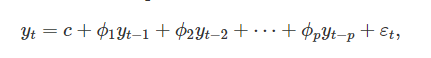

#### Autocorrelation and Partial Autocorrelation
- Identification of an AR model is often best done with the PACF.
   - For an AR model, the theoretical PACF “shuts off” past the order of the model. The phrase “shuts off” means that in theory the partial autocorrelations are equal to 0 beyond that point. Put another way, the number of non-zero partial autocorrelations gives the order of the AR model. By the “order of the model” we mean the most extreme lag of x that is used as a predictor.
- Identification of an MA model is often best done with the ACF rather than the PACF.
  - For an MA model, the theoretical ACF does not shut off, but instead tapers toward 0 in some manner. A clearer pattern for an MA model is in the ACF. The ACF will have non-zero autocorrelations only at lags involved in the model.
  
p = AR model lags 
d = differencing 
q = MA lags

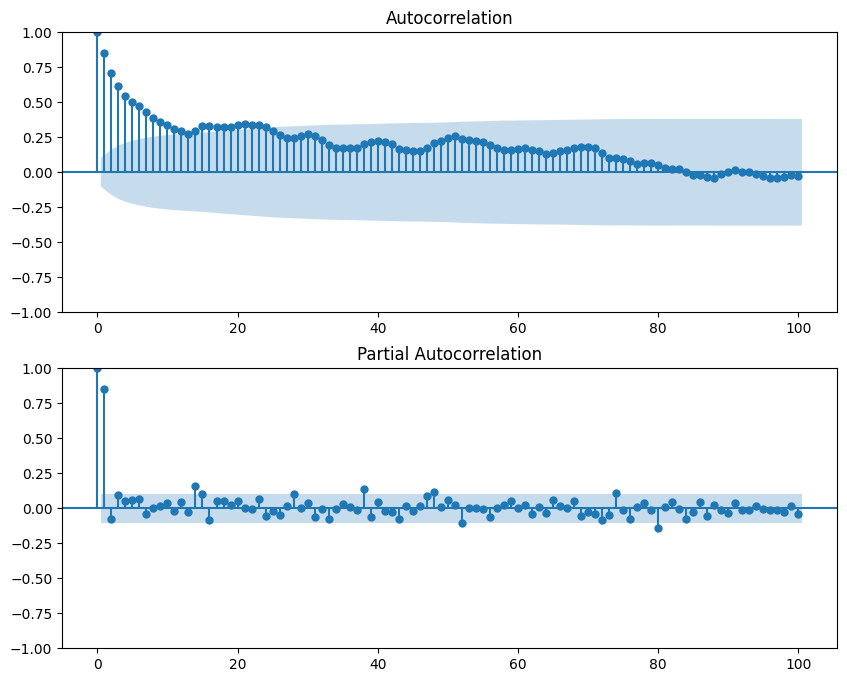

In [20]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig = plt.figure(figsize=(10, 8))

ax1 = fig.add_subplot(211)
plot_acf(df['Instagram reach'], lags=100, ax=ax1)

ax2 = fig.add_subplot(212)
plot_pacf(df['Instagram reach'], lags=100, ax=ax2)

plt.show()

## 5. Model Training

The SARIMAX model is a time series model that combines the seasonal autoregressive integrated moving average (SARIMA) model with exogenous variables. It is a powerful and flexible model that can handle time series data with both seasonal and non-seasonal components, as well as incorporate the influence of external factors.

The SARIMA model includes additional parameters to capture the seasonal patterns in the data. It takes into account the seasonal autoregressive (SAR), seasonal difference (I), and seasonal moving average (MA) components.

The SARIMAX has been trained with the values of p, d and q appropriately that has been found from analysing the ACF and PACF plots.

In [21]:
p, d, q = 5, 1, 2
import statsmodels.api as sm
import warnings
model = sm.tsa.statespace.SARIMAX(df['Instagram reach'], order = (p,d,q), seasonal_order = (p,d,q,12))
model = model.fit()
print(model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                    Instagram reach   No. Observations:                  365
Model:             SARIMAX(5, 1, 2)x(5, 1, 2, 12)   Log Likelihood               -3938.017
Date:                            Sun, 09 Jul 2023   AIC                           7906.034
Time:                                    17:32:58   BIC                           7963.988
Sample:                                         0   HQIC                          7929.097
                                            - 365                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1102      1.746      0.063      0.950      -3.312       3.533
ar.L2          0.5232      1.588   

## 6. Prediction and Visual Inspection

Now, the trained SARIMAX model is utilized for predicting the next 50 values. And then they are visualized along with the original dataset to compare the reach accuracy and continuity.

In [22]:
pred = model.predict(len(df)-50, len(df) + 50)
fig = go.Figure()
fig.add_trace(go.Scatter(x = df.index, y = df['Instagram reach'], mode = 'lines', name = 'Instagram Reach'))
fig.add_trace(go.Scatter(x = pred.index, y = pred, mode = 'lines', name = 'Predictions'))
fig.update_layout(title = 'Instagram reach Predictions', xaxis_title = 'Date', yaxis_title = 'Reach')
# Set the mathjax configuration to None
kaleido_scope = kaleido.scopes.plotly.PlotlyScope(mathjax=None)

# Save the plot as an image
pio.write_image(fig, "plot6.png", engine = "kaleido")

![Plot](plot6.png)

## The END